In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
torch.__version__

'1.0.1.post2'

In [69]:
#定义一些超参数
BATCH_SIZE = 512  #512
EPOCHS = 2       #20,需要2G显存
#查找硬件，如果有GPU则用GPU，没有则用CPU
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu")

In [70]:
###
# 加载训练数据,DataLoader的参数，例子为dataset(从中加载数据的数据集)，batch_size(每次抽取的样本数),shuffle(True:每次抽取都是随机抽取)
# transforms 来自torchvision，是pytorch中的图像预处理包
# transforms.Compose()是将多个步骤合在一起执行
# transfroms.ToTensor()将shape为(H, W, C)的nump.ndarray或img转为shape为(C, H, W)的tensor
# 其将每一个数值归一化到[0,1]，其归一化方法比较简单，直接除以255即可
# transforms.Normalize((),())第一个参数是std，第二个是mean，公式是(x-mean)/std,因为输入图片通道数为1，所以只有一个值
# datasets.MNIST的参数说明
#  root（string）– 数据集的根目录，其中存放processed/training.pt和processed/test.pt文件。
#  train（bool, 可选）– 如果设置为True，从training.pt创建数据集，否则从test.pt创建。
#  download（bool, 可选）– 如果设置为True, 从互联网下载数据并放到root文件夹下。如果root目录下已经存在数据，不会再次下载。
#  transform（可被调用 , 可选）– 一种函数或变换，输入PIL图片，返回变换之后的数据。如：transforms.RandomCrop。
#  target_transform （可被调用 , 可选）– 一种函数或变换，输入目标，进行变换。
###
train_data = datasets.MNIST('data',train=True,download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.3081,))]))

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,shuffle=True)

In [83]:
#加载测试数据
test_data = datasets.MNIST('data',train=False, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))]))
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,shuffle=True)

#print(enumerate(test_loader))
test_x = torch.unsqueeze(test_data.data,dim=1).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.targets[:2000]

In [72]:
# 定义一个网络结果
# nn.Module是所有神经网络模块的基类，自己定义的模型要继承它
# super是调用父类函数的一种方法，调用了父类函数的初始化函数
# python3.x版本super().__init__()即可，python2.x则是super(Net,self).__init__()

# class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# in_channels(int) – 输入信号的通道
# out_channels(int) – 卷积产生的通道
# kerner_size(int or tuple) - 卷积核的尺寸
# stride(int or tuple, optional) - 卷积步长
# padding(int or tuple, optional) - 输入的每一条边补充0的层数
# dilation(int or tuple, optional) – 卷积核元素之间的间距
# groups(int, optional) – 从输入通道到输出通道的阻塞连接数
# bias(bool, optional) - 如果bias=True，添加偏置

# view函数
# 第一个参数1将第一个维度的大小设定成1，后一个-1就是说第二个维度的大小=元素总数目/第一个维度的大小
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,5)   # in: 1,28x28  out: 10,24x24
        self.conv2 = nn.Conv2d(10,20,3)  # in: 10,12x12(池化之后) out: 20,10x10
        self.fc1 = nn.Linear(20*10*10,500) #in: 20*10*10(所有像素点扁平化) out: 500
        self.fc2 = nn.Linear(500,100)      #in: 500  out: 100
    
    def forward(self,x):
        # 在MNIST的数据集里面，size(0)为60000
        in_size = x.size(0)
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out,2,2)
        out = self.conv2(out)
        out = F.relu(out)
        out = out.view(in_size,-1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        # log_softmax是对softmax的结果取log
        # softmax对n维输入张量运用Softmax函数，将张量的每个元素缩放到（0,1）区间且和为1
        out = F.log_softmax(out,dim=1)
        return out

In [73]:
# 实例化一个网络，然后使用.to方法将网络移动到GPU/CPU
model = Net().to(DEVICE)

# 实例化一个优化器,参数是model的所有参数
# model.parameters()
# 返回模块参数的迭代器。 这通常被传递给优化器
optimizer = optim.Adam(model.parameters())

print(model.conv1)
print(model.fc1)

Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=2000, out_features=500, bias=True)


In [74]:
#定义训练函数
def train(model,device,train_loader,optimizer,epoch):
    # model.train() 将模式设置为训练模型,仅仅当模型中有Dropout和BatchNorm是才会有影响
    # 因为下面还有个model.eval()，这两种模式用的Dropout和BatchNorm都不同
    model.train()
    # enumerate enumerate()函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
    for batch_idx,(data,target) in enumerate(train_loader):
        # 利用.to将数据传送到GPU/CPU计算
        data,target = data.to(device),target.to(device)
        # optimizer.zero_grad() 
        # 将所有模型的参数的梯度设置为0
        optimizer.zero_grad()
        output = model(data)
        # torch.nn.functional.nll_loss(input, target, weight=None, size_average=True)
        # nll_loss和log_softmax组成了cross_entropy，可以用cross_entropy替代
        # torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True)
        loss = F.nll_loss(output,target)
        # loss反向传播
        loss.backward()
        # 优化器优化参数
        optimizer.step()
        #输出训练过程
        if(batch_idx+1)%30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),loss.item()))

In [75]:
#定义测试函数
# “with torch.no_grad(): ”：为了防止跟踪历史（和使用内存）
# 你还可以用“with torch.no_grad(): ”来包装代码块
# 这在评估一个模型时特别有用，因为模型可能有可训练参数（具有属性“requiresgrad=True”）
# 但我们并不需要整个模型的所有梯度

# torch.max()简单来说是返回一个tensor中的最大值
# troch.max()[1]， 只返回最大值的每个索引

# torch.eq()比较两个数。(001)和(010)结果就是(100) 1：true 2：false

def test(model, device, testloader):
    # 开始测试模式
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, traget = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output,target, reduction='sum').item()
            pred = output.max(1,keepdim=True)[1]
            # traget.view_as(pred) target的形状改成和pred相同的
            correct += pred.eq(traget.view_as(pred)).sum().item()
        
    test_loss /= len(test_loader.dataset)
    #输出测试结果
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [76]:
#执行函数进行网络训练
for epoch in range(1,EPOCHS+1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.342360
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.234517
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.190526

Test set: Average loss: 0.1134, Accuracy: 9674/10000 (97%)

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.079068
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.074464
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.083048

Test set: Average loss: 0.0648, Accuracy: 9799/10000 (98%)



In [78]:
# 保存网络
def save():
    # 保存整个网络
    torch.save(model,'model/MNIST_model.pkl') 
    # 保存网络的参数
    # torch.save(model.state_dict(),'model/MNIST_model_Params.pkl') 
    
save()

In [79]:
# 加载整个网络
def restore_net():
    MNIST_model = torch.load('model/MNIST_model.pkl')
    return MNIST_model

In [80]:
# 加载网络参数
def restore_params():
    MNIST_modelParams = Net()
    MNIST_modelParams.load_state_dict(torch.load('model、MNIST_modelParams'))
    return MNIST_modelParams

torch.Size([60000, 28, 28])
60000
torch.Size([60000])


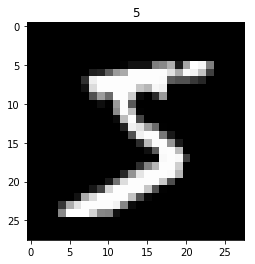

In [81]:
# 显示MNIST数据的图片
def show_data():
    #print(train_data.train_data[0])
    print(train_data.data.size())
    print(train_data.data.size(0))
    print(train_data.targets.size())
    #print(train_data.train_labels[0])
    plt.imshow(train_data.data[0].numpy(),cmap='gray')
    plt.title('%i' % train_data.targets[0])
    plt.show()

show_data()

In [86]:
# 打印前10的结果
test_output = model(test_x[10:30])
pred_y = test_output.max(1,keepdim=True)[1].data.numpy().squeeze()
print(pred_y,'prediction number')
print(test_y[10:30].numpy(),'real number')

[0 6 9 0 1 5 9 7 8 4 9 6 6 5 4 0 7 4 0 1] prediction number
[0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1] real number
